In [1]:
"""
Amplitude Estimation Benchmark Program via Phase Estimation - Qiskit
"""

import copy
import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [2]:
sys.path[1:1] = ["_common", "_common/qiskit", "quantum-fourier-transform/qiskit"]
sys.path[1:1] = ["../../_common", "../../_common/qiskit", "../../quantum-fourier-transform/qiskit"]
import execute as ex
import metrics as metrics
from qft_benchmark import inv_qft_gate

In [3]:
# Benchmark Name
benchmark_name = "Amplitude Estimation"

np.random.seed(0)

verbose = False

# saved subcircuits circuits for printing
A_ = None
Q_ = None
cQ_ = None
QC_ = None
QFTI_ = None

In [4]:
############### Circuit Definition

def AmplitudeEstimation(num_state_qubits, num_counting_qubits, a, psi_zero=None, psi_one=None):

    num_qubits = num_state_qubits + 1 + num_counting_qubits
    
    qr_state = QuantumRegister(num_state_qubits+1)
    qr_counting = QuantumRegister(num_counting_qubits)
    cr = ClassicalRegister(num_counting_qubits)
    qc = QuantumCircuit(qr_counting, qr_state, cr, name=f"qae-{num_qubits}-{a}")
    
    # create the Amplitude Generator circuit
    A = A_gen(num_state_qubits, a, psi_zero, psi_one)

    # create the Quantum Operator circuit and a controlled version of it
    cQ, Q = Ctrl_Q(num_state_qubits, A)
    
    # save small example subcircuits for visualization
    global A_, Q_, cQ_, QFTI_
    if (cQ_ and Q_) == None or num_state_qubits <= 6:
        if num_state_qubits < 9: cQ_ = cQ; Q_ = Q; A_ = A
    if QFTI_ == None or num_qubits <= 5:
        if num_qubits < 9: QFTI_ = inv_qft_gate(num_counting_qubits)

    # Prepare state from A, and counting qubits with H transform 
    qc.append(A, [qr_state[i] for i in range(num_state_qubits+1)])
    for i in range(num_counting_qubits):
        qc.h(qr_counting[i])
    
    repeat = 1
    for j in reversed(range(num_counting_qubits)):
        for _ in range(repeat):
            qc.append(cQ, [qr_counting[j]] + [qr_state[l] for l in range(num_state_qubits+1)])
        repeat *= 2
    
    qc.barrier()

    # inverse quantum Fourier transform only on counting qubits
    qc.append(inv_qft_gate(num_counting_qubits), qr_counting)

    qc.barrier()

    # measure counting qubits
    qc.measure([qr_counting[m] for m in range(num_counting_qubits)], list(range(num_counting_qubits)))

    # save smaller circuit example for display
    global QC_
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
    return qc

In [5]:
# Construct A operator that takes |0>_{n+1} to sqrt(1-a) |psi_0>|0> + sqrt(a) |psi_1>|1>
def A_gen(num_state_qubits, a, psi_zero=None, psi_one=None):

    if psi_zero==None:
        psi_zero = '0'*num_state_qubits
    if psi_one==None:
        psi_one = '1'*num_state_qubits
        
    theta = 2 * np.arcsin(np.sqrt(a))
    # Let the objective be qubit index n; state is on qubits 0 through n-1
    qc_A = QuantumCircuit(num_state_qubits+1, name="A")
    
    # takes state to |0>_{n} (sqrt(1-a) |0> + sqrt(a) |1>)
    qc_A.ry(theta, num_state_qubits)
    
    # takes state to sqrt(1-a) |psi_0>|0> + sqrt(a) |0>_{n}|1>
    qc_A.x(num_state_qubits)
    for i in range(num_state_qubits):
        if psi_zero[i]=='1':
            qc_A.cx(num_state_qubits,i)
    qc_A.x(num_state_qubits)
    
    # takes state to sqrt(1-a) |psi_0>|0> + sqrt(a) |psi_1>|1>
    for i in range(num_state_qubits):
        if psi_one[i]=='1':
            qc_A.cx(num_state_qubits,i)
    
    return qc_A

In [6]:
# Construct the grover-like operator and a controlled version of it
def Ctrl_Q(num_state_qubits, A_circ):

    # index n is the objective qubit, and indexes 0 through n-1 are state qubits
    qc = QuantumCircuit(num_state_qubits+1, name="Q")
    
    temp_A = copy.copy(A_circ)
    A_gate = temp_A.to_gate()
    A_gate_inv = temp_A.inverse().to_gate()
    
    ### Each cycle in Q applies in order: -S_chi, A_circ_inverse, S_0, A_circ 
    # -S_chi
    qc.x(num_state_qubits)
    qc.z(num_state_qubits)
    qc.x(num_state_qubits)
        
    # A_circ_inverse
    qc.append(A_gate_inv, [i for i in range(num_state_qubits+1)])
        
    # S_0
    for i in range(num_state_qubits+1):
        qc.x(i)
    qc.h(num_state_qubits)
    
    qc.mcx([x for x in range(num_state_qubits)], num_state_qubits)
    
    qc.h(num_state_qubits)
    for i in range(num_state_qubits+1):
        qc.x(i)
        
    # A_circ
    qc.append(A_gate, [i for i in range(num_state_qubits+1)])
    
    # Create a gate out of the Q operator
    qc.to_gate(label='Q')
    
    # and also a controlled version of it
    Ctrl_Q_ = qc.control(1)
    
    # and return both
    return Ctrl_Q_, qc


In [7]:
# Analyze and print measured results
# Expected result is always the secret_int (which encodes alpha), so fidelity calc is simple
def analyze_and_print_result(qc, result, num_counting_qubits, s_int, num_shots):
    
    # get results as measured counts
    counts = result.get_counts(qc) 
        
    # calculate expected output histogram
    a = a_from_s_int(s_int, num_counting_qubits)
    correct_dist = a_to_bitstring(a, num_counting_qubits)  

    # generate thermal_dist for polarization calculation
    thermal_dist = metrics.uniform_dist(num_counting_qubits)
    
    # convert counts, expectation, and thermal_dist to app form for visibility
    # app form of correct distribution is measuring amplitude a 100% of the time
    app_counts = bitstring_to_a(counts, num_counting_qubits)
    app_correct_dist = {a: 1.0}
    app_thermal_dist = bitstring_to_a(thermal_dist, num_counting_qubits)

    if verbose:
        print(f"For amplitude {a}, expected: {correct_dist} measured: {counts}")
        print(f"   ... For amplitude {a} thermal_dist: {thermal_dist}")
        print(f"For amplitude {a}, app expected: {app_correct_dist} measured: {app_counts}")
        print(f"   ... For amplitude {a} app_thermal_dist: {app_thermal_dist}")

    # use polarization fidelity with rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist, thermal_dist)
    #fidelity = metrics.polarization_fidelity(app_counts, app_correct_dist, app_thermal_dist)
    
    hf_fidelity = metrics.hellinger_fidelity_with_expected(counts, correct_dist)

    if verbose: print(f"  ... fidelity: {fidelity}  hf_fidelity: {hf_fidelity}")
    
    return counts, fidelity

def a_to_bitstring(a, num_counting_qubits):
    m = num_counting_qubits

    # solution 1
    num1 = round(np.arcsin(np.sqrt(a)) / np.pi * 2**m)
    num2 = round( (np.pi - np.arcsin(np.sqrt(a))) / np.pi * 2**m)
    if num1 != num2 and num2 < 2**m and num1 < 2**m:
        counts = {format(num1, "0"+str(m)+"b"): 0.5, format(num2, "0"+str(m)+"b"): 0.5}
    else:
        counts = {format(num1, "0"+str(m)+"b"): 1}
    return counts

def bitstring_to_a(counts, num_counting_qubits):
    est_counts = {}
    m = num_counting_qubits
    precision = int(num_counting_qubits / (np.log2(10))) + 2
    for key in counts.keys():
        r = counts[key]
        num = int(key,2) / (2**m)
        a_est = round((np.sin(np.pi * num) )** 2, precision)
        if a_est not in est_counts.keys():
            est_counts[a_est] = 0
        est_counts[a_est] += r
    return est_counts

def a_from_s_int(s_int, num_counting_qubits):
    theta = s_int * np.pi / (2**num_counting_qubits)
    precision = int(num_counting_qubits / (np.log2(10))) + 2
    a = round(np.sin(theta)**2, precision)
    return a


In [8]:
################ Benchmark Loop

# Because circuit size grows significantly with num_qubits
# limit the max_qubits here ...
MAX_QUBITS=31

# Execute program with default parameters
def run(min_qubits=3, max_qubits=13, skip_qubits=1, max_circuits=3, num_shots=1000,
        num_state_qubits=1, # default, not exposed to users
        backend_id='statevector_simulator', provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} Benchmark Program - Qiskit")

    # Clamp the maximum number of qubits
    if max_qubits > MAX_QUBITS:
        print(f"INFO: {benchmark_name} benchmark is limited to a maximum of {MAX_QUBITS} qubits.")
        max_qubits = MAX_QUBITS
        
    # validate parameters (smallest circuit is 3 qubits)
    num_state_qubits = max(1, num_state_qubits)
    if max_qubits < num_state_qubits + 2:
        print(f"ERROR: AE Benchmark needs at least {num_state_qubits + 2} qubits to run")
        return
    min_qubits = max(max(3, min_qubits), num_state_qubits + 2)
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max, state = {min_qubits} {max_qubits} {num_state_qubits}")

    # create context identifier
    if context is None: context = f"{benchmark_name} Benchmark"
    
    ##########
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, s_int, num_shots):

        # determine fidelity of result set
        num_counting_qubits = int(num_qubits) - num_state_qubits - 1
        counts, fidelity = analyze_and_print_result(qc, result, num_counting_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):

        # reset random seed
        np.random.seed(0)
        
        # as circuit width grows, the number of counting qubits is increased
        num_counting_qubits = num_qubits - num_state_qubits - 1

        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_counting_qubits), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        if verbose:
            print(f"              with num_state_qubits = {num_state_qubits}  num_counting_qubits = {num_counting_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(num_counting_qubits) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(num_counting_qubits), num_circuits, False)
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()

            a_ = a_from_s_int(s_int, num_counting_qubits)

            qc = AmplitudeEstimation(num_state_qubits, num_counting_qubits, a_)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time() - ts)

            # collapse the 3 sub-circuit levels used in this benchmark (for qiskit)
            qc2 = qc.decompose().decompose().decompose()
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, num_qubits, s_int, num_shots)

        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)

    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)

    ##########
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nControlled Quantum Operator 'cQ' ="); print(cQ_ if cQ_ != None else " ... too large!")
    print("\nQuantum Operator 'Q' ="); print(Q_ if Q_ != None else " ... too large!")
    print("\nAmplitude Generator 'A' ="); print(A_ if A_ != None else " ... too large!")
    print("\nInverse QFT Circuit ="); print(QFTI_ if QC_ != None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} - Qiskit")


Amplitude Estimation Benchmark Program - Qiskit
... execution starting at Aug 29, 2024 03:37:19 UTC
************
Executing [2] circuits with num_qubits = 3
************
Executing [3] circuits with num_qubits = 4
************
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 72, 0.422
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 58, 0.387, 29.0
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.006, 0.141, 0.003 secs
Average Transpiling, Validating, Running Times for group 3 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 5
************
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 208, 0.432
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 165, 0.398, 84.0
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.006, 0.621, 0.004 secs
Average Transpiling, Va

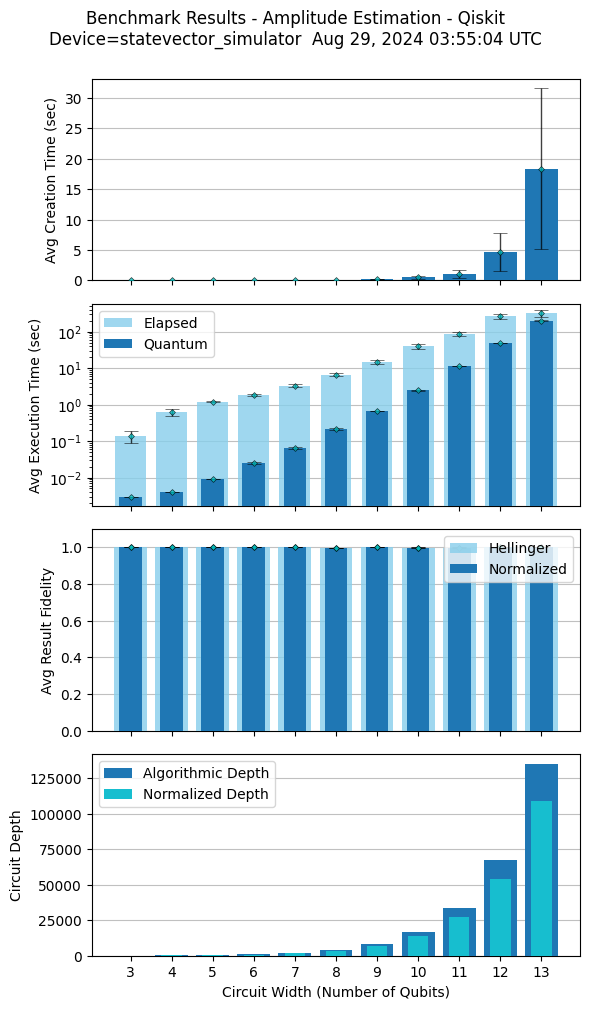

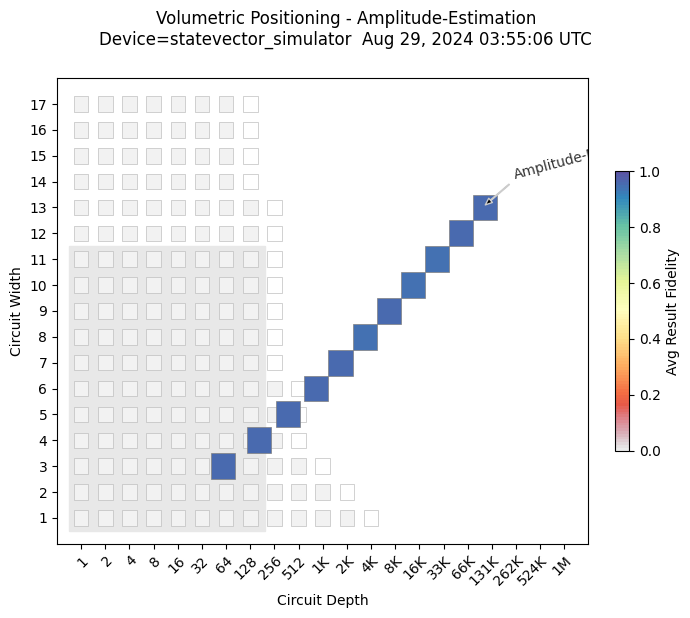

In [9]:

# if main, execute method
if __name__ == '__main__': run()
